# 정확한 이해가 필요한 개념



# 과대적합과 과소적합

앞서 영화 리뷰(분류)와 자동차 연비 예측(회귀)의 두 예제에서 일정 에포크 동안 훈련하면 검증 세트에서 모델 성능이 최고점에 도달한 다음 감소하기 시작한 것을 보았습니다.

이는 모델이 훈련 세트에 과대적합(overfitting)된 것입니다. 과대적합을 다루는 방법은 꼭 배워야 합니다. 훈련 세트에서 높은 성능을 얻을 수 있지만 진짜 원하는 것은 테스트 세트(또는 이전에 본 적 없는 데이터)에 잘 일반화되는 모델입니다.

과대적합의 반대는 과소적합(underfitting)입니다. 과소적합은 테스트 세트의 성능이 향상될 여지가 아직 있을 때 일어납니다. 발생하는 원인은 여러가지입니다.
+ 모델이 너무 단순하다.
+ 규제가 너무 많다.
+ 충분히 오래 훈련하지 않는다.

즉, 신경망이 훈련 세트에서 적절한 패턴을 학습하지 못했다는 뜻입니다.

모델을 너무 오래(에포크 많이) 훈련하면 과대적합되기 시작하고 테스트 세트에서 일반화되지 못하는 패턴을 훈련 세트에서 학습합니다. 과대적합과 과소적합 사이에서 균형을 잘 잡아야 합니다. 이를 위해 적절한 에포크 횟수동안 모델을 훈련하는 방법을 배워보겠습니다.

과대적합을 막는 가장 좋은 방법은 더 많은 훈련 데이터를 사용하는 것입니다.(오래 훈련하는 것과 다르다) 많은 데이터에서 훈련한 모델은 자연적으로 일반화 성능이 더 좋습니다.
 
데이터를 더 준비할 수 없다면 다음으로 좋은 방법은 **규제(regularization)**와 같은 기법을 사용하는 것이 있습니다. 모델이 저장할 수 있는 정보의 양과 종류에 제약을 부과하는 방법입니다. **신경망이 소수의 패턴만 기억할 수 있다면 최적화 과정동안 일반화 가능성이 높은 가장 중요한 패턴에 초점을 맞출 것입니다.**

이번 튜토리얼에서는 널리 사용되는 두 가지 규제 기법인 가중치 규제와 드롭아웃(dropout)을 알아보겠습니다. 앞서 행했던 튜토리얼 중 IMDB 영화 리뷰 분류 모델의 성능을 향상시켜 보겠습니다.


In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

## 1. IMDB 데이터셋 다운로드

이번 튜토리얼에서는 이전 튜토리얼에서처럼 임베딩을 사용하지 않고, 문장을 멀티-핫 인코딩(multi-hot encoding)으로 변환하겠습니다.

멀티-핫 인코딩은 정수 시퀀스를 0과 1로 이루어진 벡터로 변환합니다. 예를 들어, 시퀀스[3, 5]는 인덱스 3과 5만 1이고 나머지는 모두 0인 10,000 차원 벡터로 변환됩니다.

In [2]:
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=1000)

def multi_hot_sequences(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만듭니다.
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # 각 리뷰 안에 정수(특정 단어와 매핑)들에 해당되는 열의 값 1.0
    return results

train_data = multi_hot_sequences(train_data, dimension=1000)
test_data = multi_hot_sequences(test_data, dimension=1000)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

만들어진 멀티-핫 벡터 중 하나를 살펴 보겠습니다. 단어 인덱스는 빈도 순으로 정렬되어 있습니다. 그래프에서 볼 수 있듯이 인덱스 0에 가까울수록 1이 많이 등장합니다.

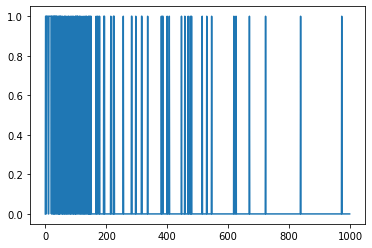

In [3]:
plt.plot(train_data[0])

## 2. 과대적합 예제

과대적합을 막는 가장 간단한 방법은 모델의 규모를 축소하는 것입니다. 즉, 모델에 있는 학습 가능한 파라미터의 수를 줄입니다(모델 파라미터는 층(layer)의 개수와 층의 유닛(unit) 개수에 의해 결정됩니다).

딥 러닝에서는 모델의 학습 가능한 파라미터의 수를 모델의 "용량"이라고 말합니다. 많은 파라미터를 가진 모델이 더 많은 "기억 용량"을 가집니다. 이런 모델은 훈련 샘플과 타깃 사이를 일반화 능력이 없는 딕셔너리와 같은 매핑으로 완벽하게 학습할 수 있습니다. 하지만 이전에 본 적 없는 데이터에서 예측을 할 땐 쓸모가 없을 것입니다.

항상 기억해야 할 점은 딥러닝 모델이 훈련 세트에는 학습이 잘 되는 경향이 있지만 진짜 해결할 문제는 학습이 아니라 일반화라는 것입니다.

그렇다고 신경망의 기억 용량이 부족하다면 매핑을 쉽게 학습할 수 없을 것입니다. "너무 많은 용량"과 "충분하지 않은 용량" 사이의 균형을 잡아야 합니다.

하지만 어떤 모델의 적절한 크기나 구조를 결정하는 공식은 없습니다. 여러 가지 다른 구조를 사용해 실험해봐야만 합니다.

알맞은 모델의 크기를 찾으려면 비교적 적은 수의 층과 파라미터로 시작해서 **검증 손실이 감소할 때까지** 새로운 층을 추가하거나 층의 크기를 늘리는 것이 좋습니다.

### 기준 모델 만들기

In [4]:
baseline_model = keras.Sequential()
baseline_model.add(keras.layers.Dense(16, activation='relu', input_shape=(1000,)))
baseline_model.add(keras.layers.Dense(16, activation='relu'))
baseline_model.add(keras.layers.Dense(1, activation='sigmoid'))

baseline_model.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                16016     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 16,305
Trainable params: 16,305
Non-trainable params: 0
_________________________________________________________________


In [5]:
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Epoch 1/20
49/49 - 4s - loss: 0.5802 - accuracy: 0.7048 - binary_crossentropy: 0.5802 - val_loss: 0.4275 - val_accuracy: 0.8174 - val_binary_crossentropy: 0.4275
Epoch 2/20
49/49 - 0s - loss: 0.3653 - accuracy: 0.8465 - binary_crossentropy: 0.3653 - val_loss: 0.3432 - val_accuracy: 0.8557 - val_binary_crossentropy: 0.3432
Epoch 3/20
49/49 - 0s - loss: 0.3230 - accuracy: 0.8670 - binary_crossentropy: 0.3230 - val_loss: 0.3321 - val_accuracy: 0.8590 - val_binary_crossentropy: 0.3321
Epoch 4/20
49/49 - 0s - loss: 0.3092 - accuracy: 0.8730 - binary_crossentropy: 0.3092 - val_loss: 0.3312 - val_accuracy: 0.8594 - val_binary_crossentropy: 0.3312
Epoch 5/20
49/49 - 0s - loss: 0.3031 - accuracy: 0.8760 - binary_crossentropy: 0.3031 - val_loss: 0.3282 - val_accuracy: 0.8594 - val_binary_crossentropy: 0.3282
Epoch 6/20
49/49 - 0s - loss: 0.3007 - accuracy: 0.8752 - binary_crossentropy: 0.3007 - val_loss: 0.3296 - val_accuracy: 0.8598 - val_binary_crossentropy: 0.3296
Epoch 7/20
49/49 - 0s - loss

### 작은 모델 만들기

앞서 만든 기준 모델과 비교하기 위해 적은 수의 Hidden unit을 가진 모델을 만들어 보겠습니다.

In [6]:
smaller_model = keras.Sequential([
                                  keras.layers.Dense(4, activation='relu', input_shape=(1000,)),
                                  keras.layers.Dense(4, activation='relu'),
                                  keras.layers.Dense(1, activation='sigmoid')
])

smaller_model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 4004      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 4,029
Trainable params: 4,029
Non-trainable params: 0
_________________________________________________________________


In [7]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Epoch 1/20
49/49 - 1s - loss: 0.6800 - accuracy: 0.5840 - binary_crossentropy: 0.6800 - val_loss: 0.6544 - val_accuracy: 0.6843 - val_binary_crossentropy: 0.6544
Epoch 2/20
49/49 - 0s - loss: 0.6071 - accuracy: 0.7337 - binary_crossentropy: 0.6071 - val_loss: 0.5442 - val_accuracy: 0.8015 - val_binary_crossentropy: 0.5442
Epoch 3/20
49/49 - 0s - loss: 0.4672 - accuracy: 0.8296 - binary_crossentropy: 0.4672 - val_loss: 0.4149 - val_accuracy: 0.8387 - val_binary_crossentropy: 0.4149
Epoch 4/20
49/49 - 0s - loss: 0.3772 - accuracy: 0.8538 - binary_crossentropy: 0.3772 - val_loss: 0.3663 - val_accuracy: 0.8510 - val_binary_crossentropy: 0.3663
Epoch 5/20
49/49 - 0s - loss: 0.3407 - accuracy: 0.8633 - binary_crossentropy: 0.3407 - val_loss: 0.3438 - val_accuracy: 0.8572 - val_binary_crossentropy: 0.3438
Epoch 6/20
49/49 - 0s - loss: 0.3216 - accuracy: 0.8692 - binary_crossentropy: 0.3216 - val_loss: 0.3343 - val_accuracy: 0.8593 - val_binary_crossentropy: 0.3343
Epoch 7/20
49/49 - 0s - loss

### 큰 모델 만들기

아주 큰 모델을 만들어 얼마나 빠르게 과대적합이 시작되는지 알아 볼 수 있습니다. 이 문제에 필요한 것보다 훨씬 더 큰 용량을 가진 신경망을 추가해서 비교해보겠습니다.

In [8]:
bigger_model = keras.Sequential([
                                 keras.layers.Dense(512, activation='relu', input_shape=(1000,)),
                                 keras.layers.Dense(512, activation='relu'),
                                 keras.layers.Dense(1, activation='sigmoid')
])

bigger_model.compile(loss='binary_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy', 'binary_crossentropy'])

bigger_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               512512    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 775,681
Trainable params: 775,681
Non-trainable params: 0
_________________________________________________________________


In [9]:
bigger_history = bigger_model.fit(train_data,
                                  train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Epoch 1/20
49/49 - 1s - loss: 0.4478 - accuracy: 0.7830 - binary_crossentropy: 0.4478 - val_loss: 0.3298 - val_accuracy: 0.8600 - val_binary_crossentropy: 0.3298
Epoch 2/20
49/49 - 0s - loss: 0.2912 - accuracy: 0.8805 - binary_crossentropy: 0.2912 - val_loss: 0.3256 - val_accuracy: 0.8576 - val_binary_crossentropy: 0.3256
Epoch 3/20
49/49 - 0s - loss: 0.2266 - accuracy: 0.9112 - binary_crossentropy: 0.2266 - val_loss: 0.3603 - val_accuracy: 0.8471 - val_binary_crossentropy: 0.3603
Epoch 4/20
49/49 - 0s - loss: 0.1148 - accuracy: 0.9631 - binary_crossentropy: 0.1148 - val_loss: 0.4077 - val_accuracy: 0.8477 - val_binary_crossentropy: 0.4077
Epoch 5/20
49/49 - 0s - loss: 0.0232 - accuracy: 0.9964 - binary_crossentropy: 0.0232 - val_loss: 0.5106 - val_accuracy: 0.8494 - val_binary_crossentropy: 0.5106
Epoch 6/20
49/49 - 0s - loss: 0.0046 - accuracy: 0.9998 - binary_crossentropy: 0.0046 - val_loss: 0.6072 - val_accuracy: 0.8516 - val_binary_crossentropy: 0.6072
Epoch 7/20
49/49 - 0s - loss

### 훈련 손실과 검증 손실 그래프 그리기

실선은 훈련 손실이고 점선은 검증 손실입니다(낮은 검증 손실이 더 좋은 모델입니다). 

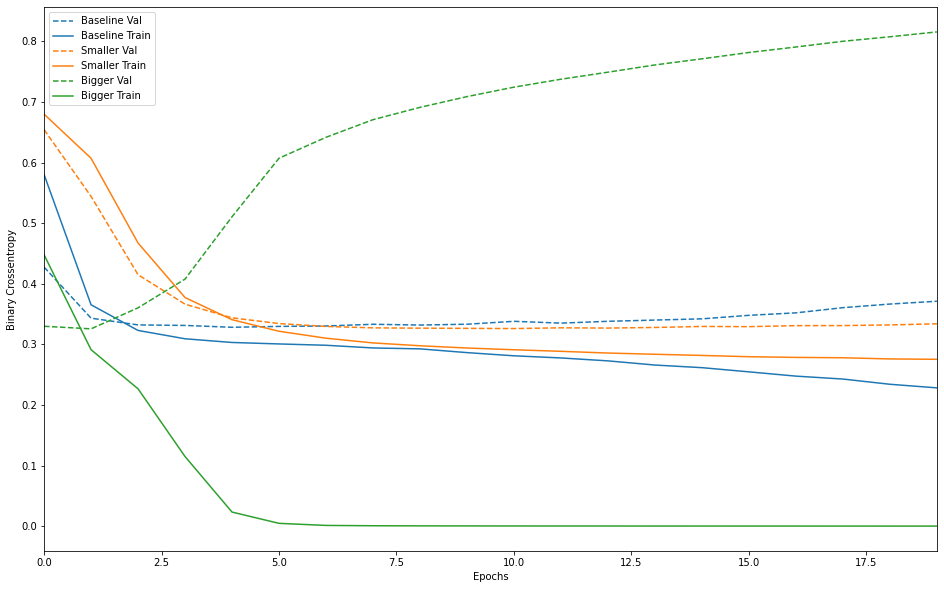

In [10]:
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(16, 10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')
        
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0, max(history.epoch)])

plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

여기서는 작은 신경망이 기준 모델보다 더 늦게 과대적합이 시작되었습니다. 또한 과대적합이 시작되고 훨씬 천천히 성능이 감소합니다.

큰 신경망은 거의 시작부터 과대적합이 시작되고 이후 더 심각하게 과대적합됩니다. 이렇듯 네트워크의 용량이 많을수록 훈련 세트를 더 빠르게 학습시킬 수 있지만 더 쉽게 과대적합됩니다.(훈련 손실과 검증 손실 사이에 큰 차이가 발생)

## 3. 과대적합을 방지하기 위한 전략

### 가중치를 규제하기

훈련 데이터와 신경망 구조가 주어졌을 때 이 데이터를 설명할 수 있는 가중치의 조합은 많습니다. 이 중에서 간단한 모델이 복잡한 모델보다 과대적합되는 경향이 작을 것입니다.

과대적합을 완화시키는 일반적인 방법은 가중치가 작은 값을 가지도록 네트워크의 복잡도에 제약을 가하는 것입니다. 이는 가중치 값의 분포를 좀 더 균일하게 만들어 줍니다. 네트워크의 손실 함수에 큰 가중치에 해당하는 비용을 추가합니다.
+ L1 규제 : 가중치의 절댓값에 비례하는 비용이 추가됩니다.
+ L2 규제 : 가중치의 제곱에 비례하는 비용이 추가됩니다.

L1 규제는 일부 가중치 파라미터를 0으로 만듭니다. L2 규제는 가중치 파라미터를 제한하지만 완전히 0으로 만들지는 않습니다. 그래서 L2 규제를 더 많이 사용합니다.

L2 가중치 규제를 추가해보겠습니다.

In [11]:
l2_model = keras.Sequential([
                             keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                                                activation='relu', input_shape=(1000,)),
                             keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                                                activation='relu'),
                             keras.layers.Dense(1, activation='sigmoid')
])

l2_model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Epoch 1/20
49/49 - 1s - loss: 0.6326 - accuracy: 0.6988 - binary_crossentropy: 0.5882 - val_loss: 0.4892 - val_accuracy: 0.8107 - val_binary_crossentropy: 0.4464
Epoch 2/20
49/49 - 0s - loss: 0.4168 - accuracy: 0.8450 - binary_crossentropy: 0.3743 - val_loss: 0.3896 - val_accuracy: 0.8542 - val_binary_crossentropy: 0.3478
Epoch 3/20
49/49 - 0s - loss: 0.3666 - accuracy: 0.8642 - binary_crossentropy: 0.3257 - val_loss: 0.3722 - val_accuracy: 0.8606 - val_binary_crossentropy: 0.3325
Epoch 4/20
49/49 - 0s - loss: 0.3503 - accuracy: 0.8711 - binary_crossentropy: 0.3114 - val_loss: 0.3677 - val_accuracy: 0.8599 - val_binary_crossentropy: 0.3299
Epoch 5/20
49/49 - 0s - loss: 0.3425 - accuracy: 0.8734 - binary_crossentropy: 0.3055 - val_loss: 0.3639 - val_accuracy: 0.8614 - val_binary_crossentropy: 0.3278
Epoch 6/20
49/49 - 0s - loss: 0.3383 - accuracy: 0.8768 - binary_crossentropy: 0.3029 - val_loss: 0.3618 - val_accuracy: 0.8612 - val_binary_crossentropy: 0.3271
Epoch 7/20
49/49 - 0s - loss

`l2(0.001)`는 신경망의 전체 손실에 층에 있는 가중치 행렬의 모든 값이 `0.001*weight_coefficient_value**2`만큼 더해진다는 의미입니다. 이런 패널티는 훈련할 때만 추가됩니다. 따라서 테스트 단계보다 훈련 단계에서 손실이 훨씬 더 클 것입니다. L2 규제의 효과를 확인해 보겠습니다.

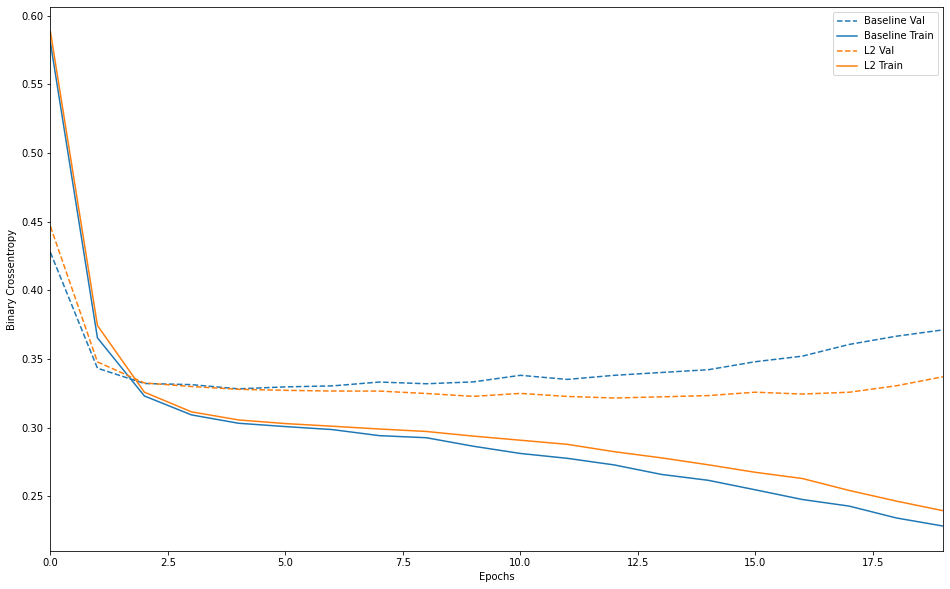

In [12]:
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

검증 손실(점선)을 보면 두 모델의 파라미터 개수는 같지만 L2 규제를 적용한 모델이 기본 모델보다 과대적합에 훨씬 더 잘 견디고 있습니다.

### 드롭아웃 추가하기

드롭아웃(dropout)은 신경망에서 가장 효과적이고 널리 사용하는 규제 기법 중 하나입니다. 드롭아웃을 층에 적용하면 훈련하는 동안 층의 출력 특성을 랜덤하게 0으로 만듭니다. 예를 들어, 훈련하는 동안 어떤 입력 샘플에 대해 [0.2, 0.5, 1.3, 0.8, 1.1]벡터를 출력하는 층이 있다고 해봅시다. 드롭아웃을 적용하면 이 벡터에서 몇 개의 원소가 랜덤하게 0이 됩니다. [0, 0.5, 1.3, 0, 1.1]가 됩니다. "드롭아웃 비율"은 전체 원소의 개수 중 0이 되는 특성의 비율입니다. 보통 0.2~0.5를 사용합니다. 테스트 단계에서는 어떤 유닛도 드롭아웃되지 않습니다. 훈련 단계보다 더 많은 유닛이 활성화되기 때문에 균형을 맞추기 위해 층의 출력 값을 드롭아웃 비율만큼 줄입니다. 

In [13]:
dpt_model = keras.Sequential([
                              keras.layers.Dense(16, activation='relu', input_shape=(1000,)),
                              keras.layers.Dropout(0.5),
                              keras.layers.Dense(16, activation='relu'),
                              keras.layers.Dropout(0.5),
                              keras.layers.Dense(1, activation='sigmoid')
])

dpt_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', 'binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels, epochs=20,
                                  batch_size=512, validation_data=(test_data, test_labels),
                                  verbose=2)

Epoch 1/20
49/49 - 1s - loss: 0.6860 - accuracy: 0.5400 - binary_crossentropy: 0.6860 - val_loss: 0.6550 - val_accuracy: 0.7196 - val_binary_crossentropy: 0.6550
Epoch 2/20
49/49 - 0s - loss: 0.6153 - accuracy: 0.6563 - binary_crossentropy: 0.6153 - val_loss: 0.5168 - val_accuracy: 0.8124 - val_binary_crossentropy: 0.5168
Epoch 3/20
49/49 - 0s - loss: 0.5120 - accuracy: 0.7534 - binary_crossentropy: 0.5120 - val_loss: 0.3996 - val_accuracy: 0.8409 - val_binary_crossentropy: 0.3996
Epoch 4/20
49/49 - 0s - loss: 0.4429 - accuracy: 0.8055 - binary_crossentropy: 0.4429 - val_loss: 0.3560 - val_accuracy: 0.8512 - val_binary_crossentropy: 0.3560
Epoch 5/20
49/49 - 0s - loss: 0.4059 - accuracy: 0.8283 - binary_crossentropy: 0.4059 - val_loss: 0.3371 - val_accuracy: 0.8551 - val_binary_crossentropy: 0.3371
Epoch 6/20
49/49 - 0s - loss: 0.3832 - accuracy: 0.8414 - binary_crossentropy: 0.3832 - val_loss: 0.3253 - val_accuracy: 0.8593 - val_binary_crossentropy: 0.3253
Epoch 7/20
49/49 - 0s - loss

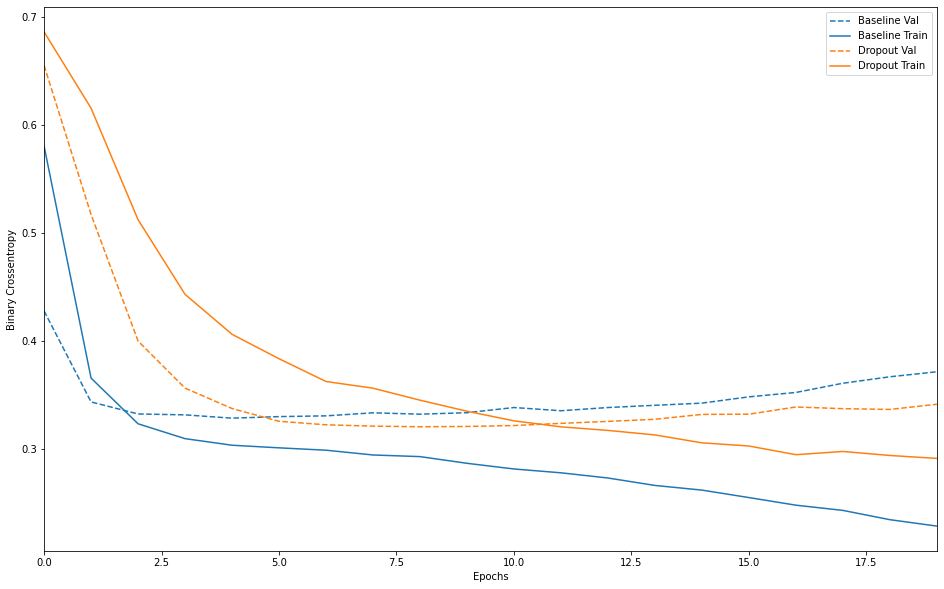

In [14]:
plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])

드롭아웃 층을 추가하니 기준 모델보다 확실히 과대적합이 늦게 찾아오는 모습을 볼 수 있으며 성능이 향상되었습니다.

## 5. 결론

신경망에서 과대적합을 방지하기 위해 가장 널리 사용하는 방법은 다음과 같습니다.

+ 더 많은 훈련 데이터를 모읍니다.
+ 네트워크의 용량을 줄입니다.
+ 가중치 규제를 추가합니다.
+ 드롭아웃을 추가합니다.

이 외에도 데이터 증식(data-augmentation)과 배치 정규화(batch normalization)이라는 두 가지 방식이 더 있습니다.